## 1) Setup & Imports

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn, optim
from torch.utils.data import DataLoader
from pathlib import Path
from sklearn.metrics import precision_recall_curve, auc

# Eigene Module importieren
from src.datasets.pcam_dataset import get_pcam_datasets
from src.models.small_cnn_gpu import SmallCNN
from src.models.resnet_pcam_gpu import ResNetPCam, ResNetConfig
from src.training.utils_training import evaluate_binary_classifier

# HIER IMPORTIEREN WIR DEINE DATEI
from src.training.imbalance import make_imbalanced_subset

# Device Setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Running on {DEVICE}")

DATA_ROOT = "data/raw"
BATCH_SIZE = 128 
NUM_EPOCHS = 20

🚀 Running on cuda


## 2) Data Preparation (10% Imbalance)

In [4]:
# Volle Datasets laden
full_datasets = get_pcam_datasets(DATA_ROOT, center_crop_size=64)

# Deine Funktion aus imbalance.py nutzen
imbalanced_train_ds, SUGGESTED_WEIGHT = make_imbalanced_subset(
    full_datasets["train"], 
    target_ratio=0.1, 
    seed=42
)

# Dataloader (Notebook-safe: num_workers=0 für Windows)
train_loader = DataLoader(imbalanced_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(full_datasets["val"], batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

⌛ Extrahiere Labels (das kann einen Moment dauern)...


## 3) Training  & PR 

In [7]:
import os
MODEL_SAVE_PATH = "models/ablation_study"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

def train_and_get_probs(model, criterion, optimizer, name):
    print(f"\n--- Training: {name} ---")

    patience = 4  # Nach 4 Epochen ohne Verbesserung abbrechen
    epochs_without_improvement = 0 
    best_val_auprc = 0.0
    best_model_state = None

    for epoch in range(1, NUM_EPOCHS + 1):
        # --- TRAINING PHASE ---
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.float().to(DEVICE)
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits.view(-1), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
        
        # --- VALIDATION PHASE (für Early Stopping) ---
        # Wir nutzen deine vorhandene evaluate_binary_classifier Funktion
        val_loss, val_auroc, val_auprc = evaluate_binary_classifier(
            model, val_loader, criterion, DEVICE
        )
        
        print(f"Epoch {epoch:02d}: Val-AUPRC = {val_auprc:.4f} (Best: {best_val_auprc:.4f})")

        # --- EARLY STOPPING LOGIK ---
        if val_auprc > best_val_auprc:
            best_val_auprc = val_auprc
            epochs_without_improvement = 0
            # Wir speichern den Zustand des besten Modells im RAM
            import copy
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"⭐ Verbesserung! Modell gemerkt.")
        else:
            epochs_without_improvement += 1
            print(f"⚠️ Keine Verbesserung ({epochs_without_improvement}/{patience})")

        if epochs_without_improvement >= patience:
            print(f"🛑 Early Stopping! Training abgebrochen in Epoche {epoch}")
            break

    # --- FINISH ---
    # Lade das beste Modell zurück, bevor wir die Vorhersagen generieren
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

        #--- SPEICHERN ----
        save_file = os.path.join(MODEL_SAVE_PATH, f"{name}_best_model_ablation.pth")
        torch.save(best_model_state, save_file)
        print(f"Bestes Modell gespeichert unter: {save_file}")

    # Vorhersagen für den PR-Plot generieren
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = torch.sigmoid(model(images.to(DEVICE)))
            all_probs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    return np.array(all_labels), np.array(all_probs)

results_data = {}

## 4) Run 4 Experiments

In [ ]:
# 1. Small CNN Standard
m1 = SmallCNN(dropout_p=0.2).to(DEVICE)
y_true, p1 = train_and_get_probs(m1, nn.BCEWithLogitsLoss(), optim.Adam(m1.parameters(), lr=1e-3), "CNN_Std")
results_data["CNN_Standard"] = (y_true, p1)

# 2. Small CNN Weighted
m2 = SmallCNN(dropout_p=0.2).to(DEVICE)
w = torch.tensor([SUGGESTED_WEIGHT]).to(DEVICE)
y_true, p2 = train_and_get_probs(m2, nn.BCEWithLogitsLoss(pos_weight=w), optim.Adam(m2.parameters(), lr=1e-3), "CNN_Weighted")
results_data["CNN_Weighted"] = (y_true, p2)

# 3. ResNet Standard
m3 = ResNetPCam(ResNetConfig(tl_mode="partial")).to(DEVICE)
y_true, p3 = train_and_get_probs(m3, nn.BCEWithLogitsLoss(), optim.Adam(m3.parameters(), lr=1e-4), "ResNet_Std")
results_data["ResNet_Standard"] = (y_true, p3)

# 4. ResNet Weighted
m4 = ResNetPCam(ResNetConfig(tl_mode="partial")).to(DEVICE)
y_true, p4 = train_and_get_probs(m4, nn.BCEWithLogitsLoss(pos_weight=w), optim.Adam(m4.parameters(), lr=1e-4), "ResNet_Weighted")
results_data["ResNet_Weighted"] = (y_true, p4)



--- Training: CNN_Std ---
Epoch 01: Val-AUPRC = 0.8570 (Best: 0.0000)
⭐ Verbesserung! Modell gemerkt.
Epoch 02: Val-AUPRC = 0.8866 (Best: 0.8570)
⭐ Verbesserung! Modell gemerkt.
Epoch 03: Val-AUPRC = 0.8945 (Best: 0.8866)
⭐ Verbesserung! Modell gemerkt.
Epoch 04: Val-AUPRC = 0.8958 (Best: 0.8945)
⭐ Verbesserung! Modell gemerkt.
Epoch 05: Val-AUPRC = 0.8914 (Best: 0.8958)
⚠️ Keine Verbesserung (1/4)
Epoch 06: Val-AUPRC = 0.9196 (Best: 0.8958)
⭐ Verbesserung! Modell gemerkt.
Epoch 07: Val-AUPRC = 0.9242 (Best: 0.9196)
⭐ Verbesserung! Modell gemerkt.
Epoch 08: Val-AUPRC = 0.9174 (Best: 0.9242)
⚠️ Keine Verbesserung (1/4)
Epoch 09: Val-AUPRC = 0.9250 (Best: 0.9242)
⭐ Verbesserung! Modell gemerkt.
Epoch 10: Val-AUPRC = 0.9039 (Best: 0.9250)
⚠️ Keine Verbesserung (1/4)
Epoch 11: Val-AUPRC = 0.9284 (Best: 0.9250)
⭐ Verbesserung! Modell gemerkt.
Epoch 12: Val-AUPRC = 0.9223 (Best: 0.9284)
⚠️ Keine Verbesserung (1/4)
Epoch 13: Val-AUPRC = 0.9226 (Best: 0.9284)
⚠️ Keine Verbesserung (2/4)
Epoch

## 5) Visualization

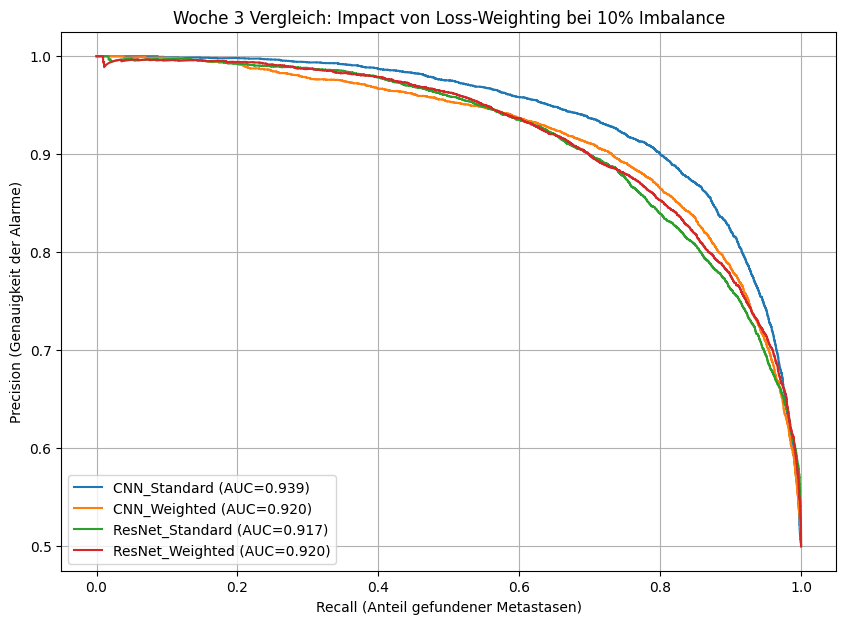

In [9]:
plt.figure(figsize=(10, 7))

for name, (y_t, y_p) in results_data.items():
    precision, recall, _ = precision_recall_curve(y_t, y_p)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (AUC={pr_auc:.3f})")

plt.xlabel("Recall (Anteil gefundener Metastasen)")
plt.ylabel("Precision (Genauigkeit der Alarme)")
plt.title("Woche 3 Vergleich: Impact von Loss-Weighting bei 10% Imbalance")
plt.legend()
plt.grid(True)
plt.show()